# 2d poissson equation
---
$$
\begin{aligned}
&\frac{d^2 u}{dx^2} + \frac{d^2 u}{dy^2} = -2\sin(x)\sin(y), \ x, y \in [-\pi, \pi]^2, \\
&u(x, -\pi) = u(x, \pi) = u(-\pi, y) = u(\pi, y) = 0.
\end{aligned}
$$

Solution:
$$
u(x) = \sin(x)\sin(y).
$$

In [1]:
import flax, flax.nn
from flax import jax_utils, optim
from flax.training import lr_schedule

import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [2]:
def random_layer_params(m, n, key):
	w_key, b_key = random.split(key)
	return jax.nn.initializers.glorot_uniform()(w_key, (m, n)), jax.nn.initializers.zeros(b_key, (n, ))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(key, layers):
	keys = random.split(key, len(layers))
	return [random_layer_params(m, n, k) for m, n, k in zip(layers[:-1], layers[1:], keys)]

layers = [2, 128, 128, 128, 128, 1]
params = init_network_params(random.PRNGKey(0), layers)

@jax.jit
def scalar_model(params, x, y):
	x_ = jnp.hstack([x, y])
	for w, b in params[:-1]:
		x_ = jnp.tanh(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0]) + params[-1][1])

model = jax.jit(jax.vmap(scalar_model, in_axes = (None, 0, 0)))

In [3]:
@jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def scalar_du_dx(params, x, y):
	return jnp.sum(jax.grad(scalar_model, 1)(params, x, y))

@jax.jit
def scalar_du_dy(params, x, y):
	return jnp.sum(jax.grad(scalar_model, 2)(params, x, y))

@jax.jit
def du_dxx(params, x, y):
	return jax.grad(scalar_du_dx, 1)(params, x, y)

@jax.jit
def du_dyy(params, x, y):
	return jax.grad(scalar_du_dy, 2)(params, x, y)

@jax.jit
def loss_fn_(params, batch):
	b, c = batch["b"], batch["c"]
	u_b = model(params, b.x, b.y).reshape((-1, 1))
	loss_c = mse(du_dxx(params, c.x, c.y).reshape((-1, 1)) + du_dyy(params, c.x, c.y).reshape((-1, 1)), -2*jnp.sin(c.x)*jnp.sin(c.y))
	loss_br = mse(du_dxx(params, b.x, b.y).reshape((-1, 1)) + du_dyy(params, b.x, b.y).reshape((-1, 1)), -2*jnp.sin(b.x)*jnp.sin(b.y))
	loss_bv = mse(u_b, b.u)
	return loss_c, loss_br, loss_bv

@jax.jit
def loss_fn(params, batch):
	loss_c, loss_br, loss_bv = loss_fn_(params, batch)
	return loss_c + loss_br + loss_bv

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	loss_c, loss_br, loss_bv = loss_fn_(params, batch)
	return loss_c + loss_br + loss_bv, loss_c, loss_br, loss_bv

In [4]:
key = random.PRNGKey(0)
key, *subkeys = random.split(key, 3)
n_c = 10000
x_c = random.uniform(subkeys[0], (n_c, 1), minval = -jnp.pi, maxval = jnp.pi)
y_c = random.uniform(subkeys[1], (n_c, 1), minval = -jnp.pi, maxval = jnp.pi)

key, *subkeys = random.split(key, 5)
n_b = 100
x_b = jnp.vstack([random.uniform(subkeys[0], (n_b, 1), minval = -jnp.pi, maxval = jnp.pi),
				  jnp.ones((n_b, 1))*jnp.pi,
				  random.uniform(subkeys[1], (n_b, 1), minval = -jnp.pi, maxval = jnp.pi),
				  jnp.ones((n_b, 1))*-jnp.pi])
y_b = jnp.vstack([jnp.ones((n_b, 1))*-jnp.pi,
				  random.uniform(subkeys[2], (n_b, 1), minval = -jnp.pi, maxval = jnp.pi),
				  jnp.ones((n_b, 1))*jnp.pi,
				  random.uniform(subkeys[3], (n_b, 1), minval = -jnp.pi, maxval = jnp.pi)])
f = lambda x, y: jnp.sin(x)*jnp.sin(y)
u_b = f(x_b, y_b)

Data = namedtuple("Data", ["x", "y", "u"])
dataset = {"c": Data(x_c, y_c, None),
		   "b": Data(x_b, y_b, u_b)}

x_test = jnp.linspace(-jnp.pi, jnp.pi, 100).reshape((-1, 1))
y_test = x_test
xy_test = tensor_grid([x_test, y_test])
u_test = f(xy_test[:, 0:1], xy_test[:, 1:2])

test_dataset = {"c": Data(xy_test[:, 0:1], xy_test[:, 1:2], None),
			   "b": Data(xy_test[:, 0:1], xy_test[:, 1:2], u_test)}

In [5]:
opt_init, opt_update, get_params = optimizers.adam(1e-4)
opt_state = opt_init(params)
for iteration in range(1, 10001):
	opt_state = step(iteration, opt_state, dataset)
	if iteration % 1000 == 0:
		names = ("Loss", "c", "br", "bv")
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, evaluate(get_params(opt_state), dataset))]))
		print("{}, Iteration: {}, Test".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, evaluate(get_params(opt_state), test_dataset))]))
		print("\n")

2020/07/22, 14:13:46, Iteration: 1000, Train Loss: 1.4762e-02, c: 2.4597e-03, br: 1.6806e-03, bv: 1.0621e-02
2020/07/22, 14:13:47, Iteration: 1000, Test Loss: 6.5708e-03, c: 2.4313e-03, br: 2.4313e-03, bv: 1.7083e-03


2020/07/22, 14:13:55, Iteration: 2000, Train Loss: 1.2160e-03, c: 3.6111e-04, br: 1.8839e-04, bv: 6.6651e-04
2020/07/22, 14:13:55, Iteration: 2000, Test Loss: 8.3080e-04, c: 3.6041e-04, br: 3.6041e-04, bv: 1.0998e-04


2020/07/22, 14:14:01, Iteration: 3000, Train Loss: 2.1920e-04, c: 7.8800e-05, br: 3.1888e-05, bv: 1.0852e-04
2020/07/22, 14:14:01, Iteration: 3000, Test Loss: 1.7277e-04, c: 7.7933e-05, br: 7.7933e-05, bv: 1.6906e-05


2020/07/22, 14:14:08, Iteration: 4000, Train Loss: 9.3912e-05, c: 3.1585e-05, br: 1.4694e-05, bv: 4.7634e-05
2020/07/22, 14:14:08, Iteration: 4000, Test Loss: 7.0433e-05, c: 3.1399e-05, br: 3.1399e-05, bv: 7.6355e-06


2020/07/22, 14:14:14, Iteration: 5000, Train Loss: 2.1204e-04, c: 2.2811e-05, br: 3.2127e-05, bv: 1.5710e-04
2020/07/22, 14:

In [6]:
# %timeit model(params, x_b, y_b).block_until_ready()
# %timeit model(params, x_c, y_c).block_until_ready()

# du_dx = jax.vmap(scalar_du_dx, in_axes = (None, 0, 0))
# %timeit du_dx(params, x_b, y_b).block_until_ready()
# %timeit du_dxx(params, x_b, y_b).block_until_ready()

# %timeit du_dx(params, x_c, y_c).block_until_ready()
# %timeit du_dxx(params, x_c, y_c).block_until_ready()

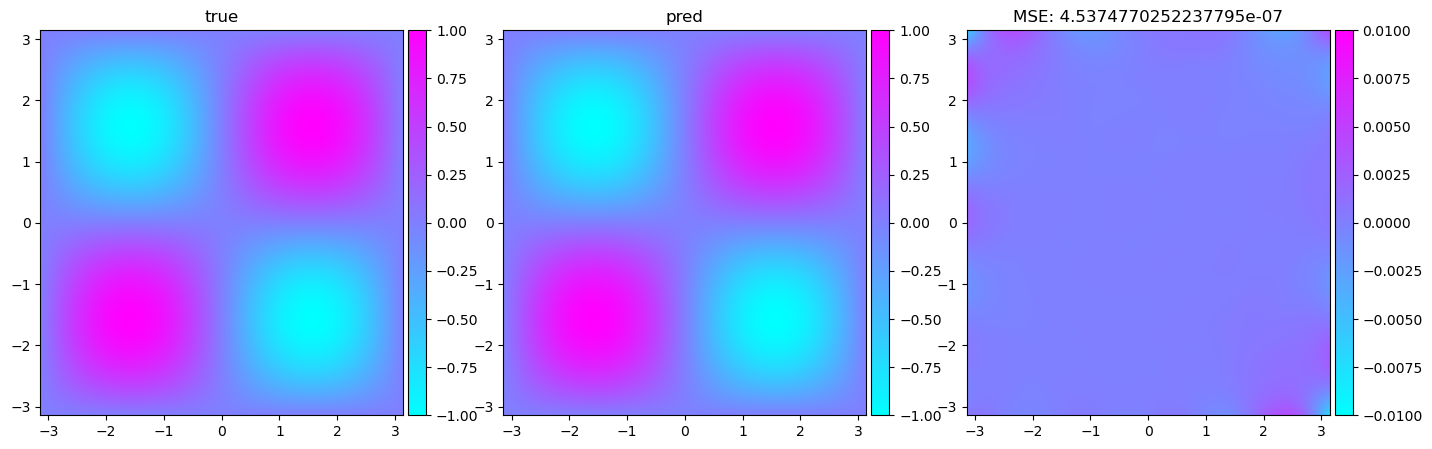

In [7]:
u_pred = model(get_params(opt_state), xy_test[:, 0:1], xy_test[:, 1:2]).reshape((-1, 1))

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

cmap = cool
norm = Normalize(vmin=-1.0, vmax=1.0)

X, Y = np.meshgrid(x_test, y_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Y, u_test.reshape((len(y_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
im1 = ax[1].contourf(X, Y, u_pred.reshape((len(y_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, Y, u_test.reshape((len(y_test), len(x_test)))-u_pred.reshape((len(y_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[2].set_title("MSE: {}".format(np.mean(np.square(u_test - u_pred))))
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()